# Loading datasets into a dataframe

last update: 2025-12-24

In [0]:
storage_account = "lab94290"  
container = "airbnb"

# Reading airbnb data from Parquet.

In [0]:
sas_token="sp=rle&st=2025-12-24T17:37:04Z&se=2026-02-28T01:52:04Z&spr=https&sv=2024-11-04&sr=c&sig=a0lx%2BS6PuS%2FvJ9Tbt4NKdCJHLE9d1Y1D6vpE1WKFQtk%3D"
sas_token = sas_token.lstrip('?')
spark.conf.set(f"fs.azure.account.auth.type.{storage_account}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{storage_account}.dfs.core.windows.net", sas_token)

In [0]:
path = f"abfss://{container}@{storage_account}.dfs.core.windows.net/airbnb_1_12_parquet"

airbnb = spark.read.parquet(path)
display(airbnb.limit(5))

name price image description category availability discount reviews ratings seller_info breadcrumbs location lat long guests pets_allowed description_items category_rating house_rules details highlights arrangement_details amenities images available_dates url final_url listing_title property_id listing_name location_details description_by_sections description_html location_details_html is_supperhost host_number_of_reviews host_rating hosts_year host_response_rate is_guest_favorite travel_details pricing_details total_price currency cancellation_policy property_number_of_reviews country postcode_map_url host_image host_details Rental unit in Broadbeach · ★4.96 · 2 bedrooms · 2 beds · 1 bath 238 https://a0.muscache.com/pictures/50ddeaed-5302-4d0c-8200-163b2cddd071.jpg Our exceptionally stylish two bedroom, one bathroom LUXURY holiday apartment is located in the ORACLE T2, right in the heart of beautiful Broadbeach! Every corner of this gorgeous apartment overflows with style, luxury and thoughtful touches. Relax on the ocean facing balcony located directly above the manicured garden terrace and take in the relaxing views and sea breezes. This property is all class and guaranteed to satisfy even the fussiest Airbnb guest!The spaceThe photos speak for themselves. They are a true, accurate and up to date representation of our immaculately presented, squeaky clean, apartment. The furnishings are practical and comfortable and the linen and bedding are soft and luxurious. The master king bedroom opens out onto the large balcony. The second bedroom is a small internal room with a comfortable high quality queen sized bed. The second bedroom does not have a window. Each bedroom has an internal sliding door which provides access to the two way bathroom. Our apartment has been styled with a relaxing holiday in mind.Guest accessPoolSpaGymSauna and steam roomBBQ and entertaining areasGardensSecure off street parking for ONE vehicleAccess to facilities is not guaranteed and may be interrupted by routine and unexpected maintenance schedules.Other things to noteThis property accommodates up to FOUR people only. Children aged two and older are included in the four people rule. No exceptions. Infants UNDER the age of two are very welcome at our place and may stay at no additional charge however we do not provide linen or bedding. Let us know if you would like the link to a local business who hires out baby equipment (travel cots, strollers, high chairs).CHECK IN Available between 3pm and 9pm.Self check in is NOT available at this property. After hours check ins are NOT available. A 3pm check in is not guaranteed and depends on cleaning schedules. CHECK IN APPOINTMENTOur lovely host welcomes you in person on arrival. The booking guest is required to make contact with us via the booking message thread prior to their arrival day to arrange a check in time. A host will not be onsite to meet you unless you have scheduled a check in time. We always do our best to fit in with your travel schedule. IMPORTANTKeys and security fobs will only be issued to the person who made the booking. ID will be required. This is not negotiable. Please read the HOUSE RULES and CANCELLATION POLICY prior to booking our place. We recommend taking out travel insurance to cover any losses which may occur if you need to cancel your booking for an unforeseen reason. NO SMOKING - smoking is NOT permitted anywhere at this complex.CHECK IN / CHECK OUT - NOT AVAILABLE* Christmas Day* New Years Day * Easter SundayEARLY CHECK IN - We will always accommodate an early check in if our place is available. CHECK OUT by 11am - Late check outs are not available and hold up our cleaning team. WHAT WE INCLUDE IN OUR STARTER PACKOur starter pack is designed to help get you started on your holiday and may not last the entire trip. If you are with us for more than two nights, you may need to re stock items at the local supermarket. Woolworths supermarket is located right next door for any additi

# Linear Regression

In [0]:
# Setup & Config

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os

# =============================
# GLOBAL CONFIGURATION / HYPERPARAMETERS
# =============================

# -------- Data filtering --------
MIN_REVIEWS = 10
# Minimum number of reviews required for a listing to be included in the analysis.
# Higher values increase reliability but reduce sample size.

# -------- Ridge regression --------
RIDGE_ALPHAS = [0.1, 1.0, 10.0, 50.0]
# Candidate regularization strengths for RidgeCV.
# Higher values = stronger regularization (more bias, less variance).

# -------- Bootstrap confidence --------
N_BOOTSTRAP = 200
# Number of bootstrap resamples used to estimate confidence.
# Higher = more stable confidence estimates, slower runtime.

BOOTSTRAP_RANDOM_STATE = 42
# Random seed for reproducible bootstrap confidence scores.

# -------- Recommendation limits --------
TOP_K_SINGLE = 3
# Number of single-amenity upgrade recommendations per category.

TOP_K_INTERACTION = 3
# Number of interaction-based upgrade recommendations.

# -------- Scoring weights --------
WEIGHT_PRICE = 0.7
WEIGHT_RATING = 0.3
# Relative importance of price vs rating in OVERALL recommendations.
# Must sum to 1.0.

# -------- Rating constraints --------
MAX_RATING = 5.0
# Upper bound for ratings (used to avoid impossible values like >5.0).

# -------- Expected rating model config --------
USE_PRICE_IN_EXPECTED_RATING = True
# If True, expected-rating model will explicitly depend on price (log_price),
# reflecting that guests form higher expectations for more expensive listings.

PRICE_COL = "price_per_night"

# =============================
# Spark session
# =============================
spark = (
    SparkSession.builder
    .appName("AmenityUpgradeAdvisor-LinearRegression")
    .master("local[*]")
    .getOrCreate()
)

# =============================
# 0) Load CSV
# =============================
df = airbnb.drop("price") if "price" in airbnb.columns else airbnb # drop "price" if it exists

# Prefer property_id as the primary identifier
ID_COL_CANDIDATES = ["property_id", "listing_id", "id"]
id_col = next((c for c in ID_COL_CANDIDATES if c in df.columns), None)

if id_col is None:
    df = df.withColumn("property_id", F.monotonically_increasing_id())
    id_col = "property_id"

In [0]:
# Parse JSON + amenity_name_value

# =============================
# 1) Parse JSON columns
# =============================
amenities_schema = ArrayType(
    StructType([
        StructField("group_name", StringType(), True),
        StructField("items", ArrayType(
            StructType([
                StructField("name", StringType(), True),
                StructField("value", StringType(), True)
            ])
        ), True)
    ])
)

seller_schema = StructType([
    StructField("seller_id", StringType(), True),
    StructField("url", StringType(), True),
])

pricing_schema = StructType([
    StructField("airbnb_service_fee", DoubleType(), True),
    StructField("aairbnb_service_fee", DoubleType(), True),  # יש לך דוגמה עם typo כזה
    StructField("cleaning_fee", DoubleType(), True),
    StructField("initial_price_per_night", DoubleType(), True),
    StructField("num_of_nights", IntegerType(), True),
    StructField("price_per_night", DoubleType(), True),
    StructField("price_without_fees", DoubleType(), True),
    StructField("special_offer", DoubleType(), True),
    StructField("taxes", DoubleType(), True),
])

df = (
    df
    .withColumn("ratings", F.expr("try_cast(ratings as double)"))

    .withColumn("pricing_parsed", F.from_json(F.col("pricing_details"), pricing_schema))
    .withColumn("price_per_night", F.col("pricing_parsed.price_per_night"))

    .withColumn("amenities_parsed", F.from_json(F.col("amenities"), amenities_schema))
    .withColumn("reviews_parsed", F.from_json(F.col("reviews"), ArrayType(StringType())))
    .withColumn("num_reviews", F.size(F.col("reviews_parsed")))
    .withColumn("seller_parsed", F.from_json(F.col("seller_info"), seller_schema))
)

df = df.withColumn("host_id", F.col("seller_parsed.seller_id"))

# Flatten amenities to (name, value) pairs (lowercase)
df = df.withColumn(
    "amenity_name_value",
    F.expr("""
        transform(
            flatten(
                transform(amenities_parsed, g -> g.items)
            ),
            x -> struct(
                lower(x.name) as name,
                lower(x.value) as value
            )
        )
    """)
)

df.write.mode("overwrite").parquet("dbfs:/airbnb/df_base")

In [0]:
# Load Parsed Base DF
df = spark.read.parquet("dbfs:/airbnb/df_base")

In [0]:
# Amenity Inventory

amenities_exploded = (
    df
    .select(
        F.col("property_id"),
        F.explode("amenity_name_value").alias("a")
    )
    .select(
        F.col("property_id"),
        F.col("a.name").alias("amenity_name")
    )
)

amenity_inventory = (
    amenities_exploded
    .groupBy("amenity_name")
    .agg(
        F.countDistinct("property_id").alias("n_properties")
    )
    .orderBy(F.desc("n_properties"))
)

display(amenity_inventory)
amenity_inventory.write.mode("overwrite").parquet("dbfs:/airbnb/amenity_inventory")


amenity_name,n_properties
kitchen,1817149
smoke alarm,1718954
wifi,1715041
hot water,1650531
essentials,1643562
carbon monoxide alarm,1572086
hair dryer,1354661
hangers,1346194
cooking basics,1313916
dishes and silverware,1307650


In [0]:
# Load Amenity Inventory + select amenities
amenity_inventory = spark.read.parquet(
    "dbfs:/airbnb/amenity_inventory"
)

MIN_PROPERTIES = 2000

selected_amenities_df = (
    amenity_inventory
    .filter(F.col("n_properties") >= MIN_PROPERTIES)
)

amenities_to_test = [
    r["amenity_name"] for r in selected_amenities_df.collect()
]

print(f"{len(amenities_to_test)} amenities selected.")

594 amenities selected.


In [0]:
# Add Amenity Flags

def col_name(a: str) -> str:
    return "a_" + "".join(ch if ch.isalnum() else "_" for ch in a.lower())

def add_amenity_flag(df_in, amenity: str):
    a = amenity.lower()
    c = col_name(a)

    return df_in.withColumn(
        c,
        F.when(
            F.exists(
                F.col("amenity_name_value"),
                lambda x: (
                    F.contains(x["name"], F.lit(a)) &
                    F.regexp_like(x["value"], F.lit("no_"))
                )
            ),
            F.lit(0)
        ).when(
            F.exists(
                F.col("amenity_name_value"),
                lambda x: (
                    F.contains(x["name"], F.lit(a)) &
                    (~F.regexp_like(x["value"], F.lit("no_")))
                )
            ),
            F.lit(1)
        ).otherwise(F.lit(0))
    )

for a in amenities_to_test:
    df = add_amenity_flag(df, a)

df.write.mode("overwrite").parquet("dbfs:/airbnb/df_with_amenities")

In [0]:
# Load DF with Amenities
df = spark.read.parquet("dbfs:/airbnb/df_with_amenities")

In [0]:
# Filter + Feature Engineering
# Collect actual amenity columns that exist in the dataframe
amenity_cols_existing = [c for c in df.columns if c.startswith("a_")]
amenity_set = set(amenity_cols_existing)


# =============================
# 3) Filter for reliable analysis + print breakdown (ONCE)
# =============================

total_raw = df.count()

df_price_ok = df.filter(F.col(PRICE_COL).isNotNull() & (F.col(PRICE_COL) > 0))
n_price_ok = df_price_ok.count()

df_rating_ok = df_price_ok.filter(F.col("ratings").isNotNull())
n_rating_ok = df_rating_ok.count()

df_reviews_ok = df_rating_ok.filter(F.col("num_reviews") >= MIN_REVIEWS)
n_reviews_ok = df_reviews_ok.count()

df_f = df_reviews_ok.withColumn("log_price", F.log(F.col(PRICE_COL)))

# Cache the filtered, feature-rich dataframe (used many times later)
df_f = df_f.cache()
df_f.count()  # materialize cache

print("\n=== Analysis Sample Explanation ===")
print(f"Total listings in raw dataset: {total_raw}")
print(f"Listings used for statistical analysis: {n_reviews_ok}")
print("\nListings were INCLUDED in the analysis only if they satisfy ALL of the following:")
print(f"  • After price_per_night filter (price_per_night > 0): {n_price_ok} (removed {total_raw - n_price_ok})")
print(f"  • After rating filter (rating available): {n_rating_ok} (removed {n_price_ok - n_rating_ok})")
print(f"  • After review-count filter (≥ {MIN_REVIEWS} reviews): {n_reviews_ok} (removed {n_rating_ok - n_reviews_ok})")


# =============================
# 3.5) Control features (non-actionable)
# =============================
df_f = (
    df_f
    .withColumn("guests", F.expr("try_cast(guests as int)"))
    .withColumn(
        "num_beds",
        F.when(
            F.col("arrangement_details").isNotNull(),
            F.regexp_count(F.lower(F.col("arrangement_details")), F.lit("bed"))
        ).otherwise(0)
    )
    .withColumn("is_superhost", F.expr("CASE WHEN is_supperhost = TRUE THEN 1 ELSE 0 END"))
    .withColumn("host_rating", F.expr("try_cast(host_rating as double)"))
    .withColumn("host_reviews", F.expr("try_cast(host_number_of_reviews as int)"))
)

# =============================
# Amenity interaction features
# =============================
INTERACTION_PAIRS = [
    # Work / business
    ("a_wifi", "a_dedicated_workspace"),
    ("a_wifi", "a_self_check_in"),

    # Kitchen completeness
    ("a_kitchen", "a_cooking_basics"),
    ("a_kitchen", "a_dishwasher"),
    ("a_oven", "a_baking_sheet"),
    ("a_coffee", "a_kettle"),

    # Outdoor / leisure
    ("a_patio_or_balcony", "a_outdoor_furniture"),
    ("a_bbq_grill", "a_outdoor_dining_area"),
    ("a_backyard", "a_bbq_grill"),
    ("a_private_backyard___fully_fenced", "a_pets_allowed"),

    # Views
    ("a_sea_view", "a_patio_or_balcony"),
    ("a_city_skyline_view", "a_patio_or_balcony"),
    ("a_garden_view", "a_outdoor_furniture"),

    # Long stay
    ("a_washing_machine", "a_drying_rack_for_clothing"),
    ("a_washing_machine", "a_iron"),

    # Family
    ("a_crib", "a_high_chair"),
    ("a_children_s_books_and_toys", "a_children_s_dinnerware"),

    # Comfort
    ("a_bed_linens", "a_extra_pillows_and_blankets"),
    ("a_room_darkening_shades", "a_ceiling_fan"),

    # Safety / trust
    ("a_smoke_alarm", "a_fire_extinguisher"),
    ("a_first_aid_kit", "a_smoke_alarm"),
]

# Create ONLY valid interaction features (both sides must exist)
valid_interactions = []

for a, b in INTERACTION_PAIRS:
    if a in amenity_set and b in amenity_set:
        inter_col = f"{a}__x__{b}"
        df_f = df_f.withColumn(inter_col, F.col(a) * F.col(b))
        valid_interactions.append(inter_col)

print("Created interaction features")

# =============================
# 4) Build Pandas dataset for regression
# =============================
amenity_features = [col_name(a) for a in amenities_to_test]

# NON_ACTIONABLE amenities (not actionable for upgrade recommendations)
NON_ACTIONABLE = {
    "a_sea_view",
    "a_city_skyline_view",
    "a_garden_view",
    "a_elevator"
}

# Interaction features
interaction_features = valid_interactions

control_features = [
    "guests",
    "num_beds",
    "is_superhost",
    "host_rating",
    "host_reviews"
]

feature_cols = [c for c in (amenity_features + interaction_features + control_features) if c in df_f.columns]

df_f = (
    df_f
    .withColumn("desc_len", F.length(F.coalesce(F.col("description"), F.lit(""))))
    .withColumn("num_reviews_text", F.coalesce(F.size(F.col("reviews_parsed")), F.lit(0)))
)


OUTPUT_PATH = "dbfs:/airbnb/df_features_v1"

df_f.write.mode("overwrite").parquet(OUTPUT_PATH)


=== Analysis Sample Explanation ===
Total listings in raw dataset: 2098880
Listings used for statistical analysis: 860729

Listings were INCLUDED in the analysis only if they satisfy ALL of the following:
  • After price_per_night filter (price_per_night > 0): 1446730 (removed 652150)
  • After rating filter (rating available): 1446725 (removed 5)
  • After review-count filter (≥ 10 reviews): 860729 (removed 585996)
Created interaction features


In [0]:
# Load Features
df_f = spark.read.parquet("dbfs:/airbnb/df_features_v1")


# Add these features to the feature list
feature_cols += ["desc_len", "num_reviews_text"]

# Define rating feature list (includes log_price)
feature_cols_rating = feature_cols.copy()
if "log_price" not in feature_cols_rating:
    feature_cols_rating.append("log_price")

# --- Train on a Spark sample only (NOT full dataset) ---
MODEL_SAMPLE_FRACTION = 0.05  # 5% (tune if you want)

df_model = (
    df_f
    .sample(withReplacement=False, fraction=MODEL_SAMPLE_FRACTION, seed=42)
    .select(["ratings"] + feature_cols_rating)
)

pdf_model = df_model.toPandas()
pdf_model = pdf_model.loc[:, ~pdf_model.columns.duplicated()]

# Training subsets
pdf_price = pdf_model.dropna(subset=["log_price"]).copy()
pdf_rating = pdf_model.dropna(subset=["ratings"]).copy()


# =============================
# Helper functions for upgrade improvement calculations
# =============================
def price_improvement(current_price_per_night, price_multiplier):
    new_price_per_night = current_price_per_night * price_multiplier
    pct = (new_price_per_night / current_price_per_night - 1.0) * 100.0 if current_price_per_night > 0 else None
    return new_price_per_night, pct

def rating_improvement(current_rating, delta):
    new_rating = min(current_rating + delta, MAX_RATING)
    pct = ((new_rating - current_rating) / current_rating) * 100.0 if current_rating > 0 else None
    return new_rating, pct

# (property_id is now always present earlier)

# ===== Define feature_cols_rating for rating model (with log_price) =====
feature_cols_rating = feature_cols.copy()
if "log_price" not in feature_cols_rating:
    feature_cols_rating.append("log_price")

In [0]:
# Modeling + Bootstrap
# =============================
# 5) Ridge Regression - Price model: log(price)
# =============================
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

price_feature_order = feature_cols.copy()

X_price = pdf_price[price_feature_order].fillna(0.0)

y_price = pdf_price["log_price"]

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=RIDGE_ALPHAS))
])

ridge.fit(X_price, y_price)

# =============================
# Bootstrap-based confidence helper
# =============================
def bootstrap_variance_ridge(
    X, y, feature_names, base_pipeline,
    n_boot=N_BOOTSTRAP,
    random_state=BOOTSTRAP_RANDOM_STATE
):
    rng = np.random.RandomState(random_state)

    coef_samples = {f: [] for f in feature_names}

    for i in range(n_boot):
        X_b, y_b = resample(X, y, random_state=rng.randint(1e9))

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=base_pipeline.named_steps["ridge"].alpha_))
        ])
        model.fit(X_b, y_b)

        coefs = model.named_steps["ridge"].coef_.ravel()

        for f, c in zip(feature_names, coefs):
            coef_samples[f].append(c)

    stats = {}
    for f, values in coef_samples.items():
        v = np.array(values)
        stats[f] = {
            "mean": v.mean(),
            "var": v.var(ddof=1),
            "std": v.std(ddof=1),
            "ci_low": np.percentile(v, 2.5),
            "ci_high": np.percentile(v, 97.5)
        }

    return stats

price_stats = bootstrap_variance_ridge(
    X_price.values,
    y_price.values,
    feature_cols,
    ridge
)

coef_price = ridge.named_steps["ridge"].coef_.reshape(-1)

price_table = pd.DataFrame({
    "feature": X_price.columns.tolist(),
    "coef_log_price": coef_price,
})

price_table["price_multiplier"] = np.exp(price_table["coef_log_price"])
price_table["coef_std"] = price_table["feature"].map(lambda f: price_stats[f]["std"])
price_table["coef_var"] = price_table["feature"].map(lambda f: price_stats[f]["var"])
price_table["ci_low"] = price_table["feature"].map(lambda f: price_stats[f]["ci_low"])
price_table["ci_high"] = price_table["feature"].map(lambda f: price_stats[f]["ci_high"])

# =============================
# 6) Ridge Regression - Rating model
# =============================
rating_feature_order = feature_cols_rating.copy()

X_rating = pdf_rating[rating_feature_order].fillna(0.0)

y_rating = pdf_rating["ratings"]

ridge_rating = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=RIDGE_ALPHAS))
])

ridge_rating.fit(X_rating, y_rating)

# Print verification for log_price in rating model
print(f"Rating model includes log_price: {'log_price' in feature_cols_rating}")

rating_stats = bootstrap_variance_ridge(
    X_rating.values,
    y_rating.values,
    feature_cols_rating,
    ridge_rating
)

coef_rating = ridge_rating.named_steps["ridge"].coef_.reshape(-1)

rating_table = pd.DataFrame({
    "feature": X_rating.columns.tolist(),
    "coef_rating": coef_rating,
})

rating_table["coef_std"] = rating_table["feature"].map(lambda f: rating_stats[f]["std"])
rating_table["coef_var"] = rating_table["feature"].map(lambda f: rating_stats[f]["var"])
rating_table["ci_low"] = rating_table["feature"].map(lambda f: rating_stats[f]["ci_low"])
rating_table["ci_high"] = rating_table["feature"].map(lambda f: rating_stats[f]["ci_high"])

# =============================
# 7) Concise conclusions table (amenities only)
# =============================
final_conclusions = (
    price_table
    .merge(
        rating_table,
        on="feature",
        how="left",
        suffixes=("_price", "_rating")
    )
    .query("feature in @amenity_features")
    .rename(columns={"feature": "amenity"})
    .fillna(0.0)
    .reset_index(drop=True)
)


print("\n=== Final Amenity Impact Conclusions (Ridge Regression, Controlled) ===")
print("Interpretation: multiplicative price effect & additive rating effect, controlling for size, host, and text quality.")
print(final_conclusions.to_string(index=False))

# =============================
# 7.1) Interaction effect tables (explicit output)
# =============================
interaction_price_table = (
    price_table
    .query("feature in @interaction_features")
    .sort_values("price_multiplier", ascending=False)
    .reset_index(drop=True)
)

interaction_rating_table = (
    rating_table
    .query("feature in @interaction_features")
    .sort_values("coef_rating", ascending=False)
    .reset_index(drop=True)
)


print("\n=== Amenity Interaction Effects – PRICE ===")
print("Interpretation: joint effect beyond individual amenities.")
if interaction_price_table.empty:
    print("No interaction effects available.")
else:
    print(interaction_price_table.to_string(index=False))

print("\n=== Amenity Interaction Effects – RATING ===")
print("Interpretation: joint effect on guest satisfaction.")
if interaction_rating_table.empty:
    print("No interaction effects available.")
else:
    print(interaction_rating_table.to_string(index=False))


spark_final_conclusions = spark.createDataFrame(final_conclusions)
spark_interaction_price = spark.createDataFrame(interaction_price_table)
spark_interaction_rating = spark.createDataFrame(interaction_rating_table)

spark_final_conclusions.write.mode("overwrite").parquet("dbfs:/airbnb/final_conclusions")
spark_interaction_price.write.mode("overwrite").parquet("dbfs:/airbnb/interaction_effects_price")
spark_interaction_rating.write.mode("overwrite").parquet("dbfs:/airbnb/interaction_effects_rating")

spark.createDataFrame(price_table).write.mode("overwrite").parquet("dbfs:/airbnb/price_table")
spark.createDataFrame(rating_table).write.mode("overwrite").parquet("dbfs:/airbnb/rating_table")

print("Analysis tables saved to DBFS")

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run classy-penguin-653 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/09cbb67a6c0f448cab30c943ff966981
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run angry-perch-572 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f4910e80e4664b11be7e0ef58e1db342
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run marvelous-colt-953 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e1872e2f495b4a148e1203f3e45d89b0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adaptable-pug-645 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c8e9dd0beff54919922d715e12c36b58
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bemused-fly-770 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bba163b2a4284d25a723b641c9117d80
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run agreeable-kite-691 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/00f027432d5c46519ed61063be0c8459
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unequaled-goat-584 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e2a835807b7c47ed8ce4f9d0eaae9180
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fearless-wasp-30 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e439b71c3c784b7f812074d9cf44e3c5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-stork-26 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b8d00b48b80c4f1d8aed9b09f11907c4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fortunate-wren-749 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b3be4f3138fd49d5b6b184fdb1bfaa27
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-wasp-367 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ea3a6f44ac8b424598791f92197d62ca
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-lynx-113 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/907f9479c5d041439ec350c7d03653cf
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run invincible-cub-408 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/758bbc3b9d4446ac9c510238009f93d9
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bold-toad-955 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/88c2d1b347df4c178d6d4e20e945e85a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upbeat-goose-535 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4dc5dce3a09c448bb371114b23d67beb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run awesome-cub-726 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f0e17763454e4b7a99ea86e1795eedb6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mysterious-gnu-757 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4e3b000ea1ba4164990fd1f006cf740d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run tasteful-frog-835 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/52ab17cb76a546d89ed6311f6caaae40
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bittersweet-colt-161 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c3611f4d80484f5799ad77c83c2b2316
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unique-rat-672 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f2947756f806499d9b20299d0a02ac3e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unequaled-colt-254 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/450a9376a8134dc38d290cefbe5a3241
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stylish-jay-4 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/93c549a9453748c7a9384d1544e1c184
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-gnu-763 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/09195a15b4704b3e85f29c7c19155f92
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run thoughtful-bird-530 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3b31c9e7a0f54b0da848ae728b1bf28a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amusing-lark-948 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/03a41ab11e744e4288f26ef920721ddc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run angry-trout-0 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d9292f758f3145329de2ccf6b510be53
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gentle-snake-253 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/faae1fb5fa6b49f6a0002506b40f95c1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-koi-815 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/593ae94879344a71a4480607fe3568a4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sassy-toad-573 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3d07c9b6b8b2444188c55a48958fbaa1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fortunate-hog-710 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f64a04ceba2043a0923b665248b8a039
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run youthful-mink-4 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/422b120362394b77a899131c4fb79c88
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sincere-mink-568 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c7e3c38c67d94833af0d3b59a56b7b7f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run flawless-wolf-653 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7b1ef4179849413eb5ccf39c01209c43
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run polite-snake-34 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a1806f8535be44dd999859a180043a2c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run industrious-cub-653 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/65f682d5c45e431a88ba012e05ee7b11
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adventurous-croc-314 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b282a88cbe1740e8bf95e83478da282b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sincere-sloth-842 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b2fd1cffc9df42a29f42ca2ec74464b1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-goat-881 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5a65777a37c847ee9a70d350f56863cb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-moth-241 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6a2b237e66fe4750be9f3dc864745bdd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intrigued-cow-641 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0a6d37772a014b1c930562d800fe1ff5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-zebra-41 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a7def5e943d54ccaadbc28a1754ce70d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run delicate-moose-900 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3c65ad264b4948e08ea7fa33596785ef
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run aged-fly-517 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5fefa5cc7e034e088a7281f0e31db8a4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luminous-moth-869 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c2137730ce6a4e0585450b07283b8867
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-quail-407 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a38f3687de2442d3abf85700701951b7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-duck-929 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a5a2237df874497080358817ad8fe1f1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run delicate-lynx-296 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ef2f807c767e489f86a890cc3d35d674
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-mole-407 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4763bdf3c22547e394dba6e9ffa7ea94
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intelligent-lark-293 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/edf7ae38a88b43d5a8221efa57ab5693
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run angry-ape-934 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/73dd306cb67d45d9b8aec98b4f67f973
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run judicious-fish-502 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2756cecde4b147019275f2e1b6826cd9
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sedate-yak-945 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1afaca03fd404813975c6087c67375da
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capable-whale-335 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/36ce29717a9a46089bc4a60c892a2e9a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stately-ox-684 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ee96e63a20bf41f182c4f4ea64b8c16d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run burly-rat-643 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3fc127de36ad4efdb881172438a6706b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run colorful-crab-272 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5e3680293f4a474d8b4ffa832d58e8ce
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run ambitious-mouse-998 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/566fb794489a442688837456c476e5be
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run thoughtful-crow-420 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/17c231680f694e379ee751cc038c1234
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run salty-smelt-372 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b086066529c149e7b32e6bac5d093756
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adventurous-bug-462 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f317613d8ab741dcae72db268ef7a08f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run classy-dove-677 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e97d20f42bb54353ad8e3a0f3b646b4f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run vaunted-yak-893 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cf884bee6a8f44efb18d48b30a27cd11
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run magnificent-mole-481 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6960771660dd473a94209fb4a6cacfd8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run victorious-shoat-779 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9ed1e6620eb5411bb92e4ccae9269466
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upbeat-doe-772 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b2b4307a36a74a87a89db021dfe7054c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sneaky-moose-748 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b41e63a3778c4fb8acaf64dbbb8d0da4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run big-calf-64 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5d5fd3718cfc4956b3687debbfb62634
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-doe-192 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c7d863ac90024e4d9e171364c0691ed6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-panda-960 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8ab1a921507840efa76782165fd9c2f6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run legendary-auk-9 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/39ee7129482b4164b27ced53f212725b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luminous-fish-44 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3c92f47b6faf47c5b5cc54f7905cc399
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-steed-259 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/21ba8f6050a04cb2a1d46434bc925285
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run calm-swan-583 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8f2047088d264e54a4ace6eced112ded
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nebulous-shad-681 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b9afdd60ef8042a98732b66e980342b8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run polite-perch-150 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/99f9903c457a401e851da808bdfe4c60
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fearless-jay-500 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fd547243edc94a3b9b36bd13dccb8d70
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run illustrious-eel-754 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/70b13c6d151641c785b3c544eb0dade4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-calf-372 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a48fad345c19435c8d679ee0a0b2fb0c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run treasured-calf-739 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ddccb41f8a9b4a8ebcd6aa49cfddf6b8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capricious-smelt-27 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9d4e91351c1b4bb99719f4fb06bb09c8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run silent-finch-229 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f8510bdd0d294e0c8a2e095430f87ced
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gaudy-cow-56 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a5c94ddb588743b2ab34a48410150746
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capricious-gnat-74 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1fa11eacc4c8443e87be4f5ba7827043
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-rook-179 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/33f267066a58495087b9cb02630d93d9
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unruly-snake-942 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cae3fc9d9e8b41cdb4edeba99088e414
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stately-swan-534 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/27f7b0c393bf4131a36d974a762c6c86
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run caring-snipe-861 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fea8db4ec1e8419abb68154008cd11e3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nosy-hog-168 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8df48699ef774193a11eeab79f1051da
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-jay-594 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/32f7ea3060344bf6b8ed519718aabd99
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run colorful-gnat-496 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/16534c32770b48979bd5898a98eb7dbd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run hilarious-panda-377 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/20593eae2e0048bd9fd5fb5b090db83f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run resilient-cub-540 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7edeaad959ff4522bca166d29f653a81
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-sheep-254 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/62f0be2a04ee4424a0457c60f5daaaa2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run learned-colt-432 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0bd2afc40b5c48d7b815bf06e602a7a3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run painted-bird-584 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/56e3743607c2462f9cdfb83e482db057
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-boar-683 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/367c0d35fa3c4e8cbb55eee2dc8b8b15
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run respected-bass-638 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/44b34313c0c345a081b5c1a10fb73d5e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run exultant-bear-405 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0ead09f4e6c547c693d678be801c1d65
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intelligent-elk-838 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3ef42e64e382420e91a6ef0e978fb071
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luminous-cub-366 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/116937acdeb245c9ac3392371c053036
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-moth-862 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5794383f935045ad869dabb7c76444f8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-squid-713 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f34d5da4656442028f0649737964c1c2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rare-fly-9 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a0e0424b27734456b588db9c25a6f05a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run judicious-asp-440 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9c7177263fa141e48eab125c0cd0f259
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gifted-mouse-345 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e717dc8db1674ffcbf3536536f185a9b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bustling-robin-961 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ac8d6a54661145f3876451a637778567
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dashing-asp-635 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2819f648176e44b889bb9cf6b5142f38
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run popular-roo-775 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2201a7d98a0c4466974e680b35a69511
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run worried-grouse-81 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/521464620e894f9aa6567e50ab88422a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run polite-hawk-191 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fe7cd0eb522e4f0587d58307ca3a7c00
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run charming-vole-925 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/67b0e9a78aae45ec8a913911c564d5e6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-chimp-91 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bc5700915edb4013b68d2a7c774b6dea
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run hilarious-fly-711 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e85ea04f9f414f308312020e5b3aa424
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-ant-376 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/85c96b63ed854bd59897b0e0d22c03d2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run efficient-gnat-844 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a98ec249e1304713b32630ea0f08075f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-hare-691 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3e3485829df740148fbaa8b4604b2752
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run abrasive-snipe-668 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d9c7d923273f4aa5aa622d94c190653c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run victorious-snake-353 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0ce6cead21564329b08465a85cda45b7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-dolphin-471 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/856206d0234044d3bdc17b35326655bd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run polite-shrike-777 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bc278c5418c14566bca6e44eea10a37a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run hilarious-kite-817 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9a61aa2a6e8b4c3eb338cc6e1fe6d3c2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run painted-snail-331 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/00fcebd01a1041a4b473039b56113047
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run chill-grub-291 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fb91aa1d2e844ce9a12696a012e561aa
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unequaled-skunk-990 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f7e10cd9c8354e04b1546840a9559b67
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-stoat-802 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a680f8669a2d4ba59d680e19dca328ae
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run salty-fish-395 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/58ce87f81bf24810b437a1ea3a45ae60
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run debonair-mare-315 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/159b9a34b93c41f4bd2d5ce9e5dd59ca
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run exultant-robin-602 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/645b5253a4ca48c59bba3f7e3bbac595
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upset-mule-260 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/16aad515fce847f6be3b27e4bd33a721
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run languid-hog-159 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/13ec75ca148c4babb0a20160b35affef
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run omniscient-kit-241 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b74063b489a1493092c5cc3a3e35a2e2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-auk-962 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/936bbc8fb4364cc389f6e45d9f43e53b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run calm-skunk-66 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4d6ff32cf3094359b1ae891459a60f06
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run agreeable-mole-849 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fdc3411c5d7b45f79340f77a56bae84d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run judicious-smelt-591 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ef0ff0a20ad743dc8f6c57ff907f5c44
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-yak-11 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4b2892fec0734454aae4a7f8c71308ab
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run caring-grouse-511 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d8c3cf4f6b954cd7adb2b53be1de599c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-swan-361 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3fa6596c5c6d48389a571b411e4738f5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run marvelous-doe-599 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1be9414d131c407cba4dfa33bce3abe7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nimble-pug-184 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5d4aa64c68664144bc98c970ba7a1cee
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stately-yak-106 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7a36632d643c46e3b0a7a448343f9fb8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skittish-quail-5 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0c79b08ea9c2436e86bef2b7f8fe52a1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run exultant-shrike-386 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9765b0d9640f44d1a94990df273b933c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sassy-skunk-147 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1c417141b1e14a589e5131688bb259cd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run flawless-foal-73 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1ec18a6f5552450dbac5856031e471c6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enthused-hawk-408 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/45477fa4dfe04b428110f9b933a29125
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adorable-tern-22 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/947936fac5054da9a693d9d117585319
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run languid-horse-122 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/58dc8dc59b6e414d9939f9b4c424b000
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run worried-shrimp-948 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2dde088348324c4d9d4d998994cba021
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-shad-741 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9dd4430b1ca745ddb9283e210e79e068
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run illustrious-flea-493 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2a91f2bd8ba24c6b91e8326b34cc04ce
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run powerful-fly-64 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e5f85a7e6ccc48b5b5de4956cb7b74c9
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run loud-squid-482 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/366dff34fca24393adbbac0708b31472
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enchanting-colt-243 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cb4f86711d474d40aa3407b36c5fb52d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-quail-883 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/031b5038200f435e989ab67ef8810085
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gentle-hawk-14 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7e56fcaaaedf4724b73c6c5ad89d741b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run worried-crab-343 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9df22c53c4a64f9d9c11666bbf550930
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amusing-loon-495 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8df025b1a5a548138ec2255a4601c904
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run trusting-fawn-741 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d071e394d6854e50ba298402356357ae
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-turtle-591 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9b44ace87df94a66b68c7f57104cb9dc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-bat-707 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ab5d7ccec57646bfa352d47139d53b77
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rumbling-stoat-252 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5aa708e0c15c48d6985fa6558fff5012
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run receptive-lark-567 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b4cd71d3fe0c464abbc32ee26bfe55b8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capricious-crow-629 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8ff05a10d526430598796b8670a35dc7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-ox-46 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0605aa6ce1b44073865f9c118c5740f0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rebellious-goat-530 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a40dd43f9d7d43519c0c932d142e1c29
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run classy-shad-977 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/612f125dff904fc4b757101820d71ed5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-cod-760 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8cc5bd865d654720b9fcdb79767d9d5a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-koi-197 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/529dd1a014f24a07b5bf54df7728d47f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run learned-fish-968 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7a173c14c75c458cbf7b2090f93b1d85
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run thundering-sheep-304 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b296b1f1026e4aacbf7ef6e227eba729
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dazzling-conch-118 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f999ab05abc142eba313c298783b037d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adventurous-moth-324 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4fea3c3271ff44c289cb222586606026
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run selective-fish-521 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5664fc951ceb4fbbb157d84afa53d227
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-mole-135 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/13125cf4c0514fa2bd26a817803148de
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run omniscient-panda-182 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ae4e8518bdb044fd8dda3a1d5c52d1dd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adorable-mule-754 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6c143f098ff143b1b7ab13d64d5ecb30
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amusing-sponge-548 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/28e25dd57ae348aea402d7cd9a212ea2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run polite-turtle-744 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6a23a1af46d74fdbb36333d04e85f29b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sneaky-kit-778 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c4de38627cc04f29829f4a7ce2eb2dac
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upbeat-calf-87 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c9b26cea395a430bb3ab85708eb26802
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run abundant-mare-960 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a9cdccf8d401405b8517ce521e412944
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-pig-863 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d2dc16a0a64345bfa4b2a7f977eded03
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-eel-667 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2407aed2f12d4bad86463526ca0c7f48
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run lyrical-duck-541 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9751f79e1306438fa6add01021dc5f49
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-mink-325 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/05f3f8ba670c44ab8a4f0da133f2f377
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-snake-581 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1aec174f302440c3916d3deace328773
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bemused-foal-533 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c53fea03cdb34a95b4dab4af5e759974
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amusing-goat-840 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/64a8a18d9c8c4642b246d1f84fcf5741
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-steed-914 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/66312bba8be946e7806bf173bc7ad79a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run carefree-jay-220 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e3ba421eacd74799bd78078001089cdc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amazing-midge-625 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1ca90c143fa84db18a1a41f4c26f8411
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-crab-750 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b34c557374e445c49b2b7a6cc80316ee
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run lyrical-midge-994 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bf79eda7a70b414e88dedcab25bdbb13
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run trusting-dolphin-709 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a614d23cbb70405aa83dae2ef7db691f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skittish-mule-163 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e029878216794415b26c879cc8d25775
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-tern-240 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/acda32b52d234a9cbd725575b807ac94
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bedecked-bug-398 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4b31df431c6844e09d3481028eb66b4d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run youthful-stoat-694 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1d177e9715c4421ca2e0a600ec8b91b7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run magnificent-vole-312 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2aa4b0ae4a0a4dba81ac37088a5e9ce6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run aged-seal-946 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3ed03a77dfcc48f8a833e2cc7597b786
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intrigued-crane-761 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/616fea64dda34a128a0c512f4e68ffe4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775
Rating model includes log_price: True


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run loud-dove-641 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e85ee5b64c69413685c61a9393a905cd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fortunate-bat-394 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f5bcbfde9bcd4f6d827f0445f527ad68
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run awesome-mouse-155 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1fc6791eae124550abfa2598718fd94e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-colt-554 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3fb9da5afc934cd0b10ee2fd20f4d686
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run powerful-shrew-853 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cf761e8f38bc4f9ab79cb7478f270e6e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-roo-453 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/767902c0ee6b44edb96d530d2f97ba61
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-stag-958 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/79994dbde02a48be9eb9a31710872175
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run efficient-boar-459 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/950004d12e5148e48632d661e73e2ff2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run delicate-mouse-660 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4f6869ae889649d1be359fc39d0fdc7a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wistful-fowl-210 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/75eda1e12c9b48d68dfcc57e3ab32ccc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sassy-chimp-443 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a381f6f4dbdd4768937cd40363e8a461
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-koi-773 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ffba1e1627494488a0355ddc6d10c09b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run colorful-ray-120 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2c064aba1aba4571b644196bae552811
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-moth-86 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/83b56c6d7bcf4c7babfade035f379045
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enchanting-lark-130 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9c50a269d8be44d28f9445d2c374c582
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-rat-160 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5906672fe24a4c09802961ac126316f6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dapper-bee-433 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4e7627443cde4b86b40087bdc3269f08
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bittersweet-rat-630 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ca6bfeefb28c44bfa1c8870f69a9cc7e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run exultant-grouse-976 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8eb9cb4e9807428aa92b4cb70d2db3ae
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run delightful-skink-66 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/684d50a2e43945b1b59cd173d3d1e1fe
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-fox-632 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/28ef16c8083c4edcad5409575aaca3cd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run thundering-snipe-451 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d251d34ed9c646b49b14a463fd720c6d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run abrasive-moose-327 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3fb0da0710074ace9af2a167abcaadb7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run exultant-moose-262 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7ed2ff91373946b4b3a70f83fcd02511
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run redolent-rat-34 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/eda91409020843418aab6bc13fbed0e4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run selective-skunk-129 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f8184d97ccc241c69e4d2bc392dd60ee
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run redolent-mink-14 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/68e1161154094f7ea809bb9e96d3d240
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gifted-mouse-822 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3647d2bbf47d48b380a69722c3399dcf
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run tasteful-wolf-41 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/00c87c4b646941679b4ab3d591d6b00a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run indecisive-pug-947 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/466e0c204ce24613bd69666506c49ebd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run resilient-shrew-173 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/dfa5e77ffd124257b2db4d3d72724ded
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-finch-892 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8c83ec232f7a4aefbeff1ac3b69fcdce
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gentle-panda-53 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/edec3521ae6744269ea658f4fcc10f76
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sedate-koi-36 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/643ebe087b6047419189ccacbf97bef0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run flawless-mouse-365 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cd063089dba4459cb1e145162ccccc7c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run awesome-cub-945 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d1ce898056f54b2d907b68568e83276e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wistful-bear-387 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6e47dd126de84645ad2940ee297161ff
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bemused-whale-445 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9c03c877d86d4d4ab6fe46a40f3397ef
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-doe-209 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fc43c6946d634c72904684ecab3a0603
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run spiffy-bass-824 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f8016be253194f45848ad34fde29fede
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run big-doe-743 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e4b3ce90b50c4789aba8e43a83ee9d53
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-dove-889 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/dd46ef44b31c4851a5fe98de326c7045
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run brawny-mule-436 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ad5ee297dfef4558a0149cd56391d6a1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-fly-220 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8c0637beac984cd583895475e07ca394
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run invincible-carp-284 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7425ea0597124ac483074043ae3e38e4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run persistent-crane-609 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2d0a69fa0e744c3b8b2fb6d48a47929a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nimble-skink-873 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e9cc18828689479d9d46ed5aa193100a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wistful-ray-253 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/502538961a904b8fbc4fff1bbbf72bf5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gregarious-moose-740 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a853f6bd5f6b46f0ad4d0cfc7ed0e048
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run loud-shark-482 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/126c189464e141ae9ff6156981ef6cf9
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run funny-steed-437 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2fe2957aad0d468691e4effccb8a2f70
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bold-cod-447 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/aac788096de94cc0b79c0c2bc0c21887
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bedecked-conch-728 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6172e6d1042444f092f3563b4173061d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run defiant-sheep-523 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1deedbd52c6140209a2b57e3fa2592ae
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run indecisive-frog-371 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4d60c89f61804c179f57416ea247bf0f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-snake-128 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8fb3e7f9abc54ea9a5221ade55527731
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-whale-912 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/10d2ccffea1a4c9886bfda54ecfc5948
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run judicious-sponge-624 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4c741121e0404a90a4ebaa1f0def8c73
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-sheep-689 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4697df38918440598ca635e7fdd9602a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unruly-finch-748 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e700bf7c38d7455fbe2f70d7f6c3f4e5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run able-duck-832 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7acfd172c44346a2b54468ad7b97c8b0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enthused-fawn-263 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/335d249e631545d792df62c831456558
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run aged-lamb-801 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/43e77c524bdf4c19af85435ab3812120
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run traveling-trout-61 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/16c313603ebd4d298a5fe0c6424cf86c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run thundering-duck-791 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8ccce3f37cdd40688f6057259fcb4d37
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run awesome-duck-795 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f63f9ed1734e4bda9ac513798d3d3655
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mysterious-shad-719 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e8424b15ba7049feb1899fabf8c37237
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-skunk-927 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e68e94a3698241b3b27bcfd65ac330e6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mysterious-crow-754 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9cbd902e196b497a927ff3b4e5676458
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upset-cod-769 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8731029815304c6b9e6e25a67f27ea68
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run classy-ox-535 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/283815bc92fc464b9e9e894d1220d84d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capricious-gnu-603 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/63c56721deb34cbfa5145429032e8f34
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run calm-swan-759 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e370164dd5214c19a489b88ab1314876
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amazing-rook-521 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7dc4502bbf944f36b0d547d4e8859370
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-kite-302 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/138f99fe88864a3e9237712fe174e8f5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run hilarious-donkey-559 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3442abf2b9024700a0fd369e3ade4d13
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run silent-ape-867 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/eea1bef08c10406f84bc4119e97c8b02
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run treasured-ant-156 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7413c2edf24d45b7a11cea9620d407d1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-goat-41 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f5aada17149e47158860954d5a2af668
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rare-koi-265 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a1910d107423444cae79162115c2981d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run thundering-flea-593 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4fd0ff7c43bf4d508ccfdd927719cdfc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-crane-179 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/af7fecb5ccc54c70b8c8fdfc18504499
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run brawny-skink-447 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/acee17c6da9e49859f285cfd5581cf19
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-newt-169 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8ddb3edf04574eaba07bfe76f54e843c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bustling-boar-79 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1de71459ce9444bd85a5e2100285642a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run learned-bear-565 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f059d0b9010a4d3c9e6904e513215d2e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run clean-penguin-770 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ee91a99b98e544149c5b49a9a18b8201
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run invincible-boar-590 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a11986c3a7064644b3b4e88c8137067a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run spiffy-bear-607 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/07e4c6b6e7b2490981033ac4aaa3c022
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run illustrious-bear-566 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/04ed02189bce41c9997330fc10ce4fc1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run languid-crab-941 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cb465afcf1db4c158589ac5c8226a9cd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-vole-482 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/825c4892a5dc48a78b480f66672a5f22
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-ox-696 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cc3d1db58dc343ae8696e5c3b808c03b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run worried-ox-511 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/f3a6a508afb740b68185aa8ceefe58e0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-mink-588 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/477dd57a6dbe4bb5b6b9aa1c6617e224
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run chill-cub-319 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c602262f1b0747c0a0805094c15594ae
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run agreeable-donkey-717 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1b9b5d5ef8bd48b797245a4bf56901d8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run puzzled-cat-753 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a2fd7986a62f45e083db9938755781fb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amusing-quail-258 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b1cad09605fa44289e4371a27a2af4a8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stylish-robin-282 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b78f2c0a0ac846698a395475417d314a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-bird-545 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b723def47867492db4b9463c0700c07e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run whimsical-gnu-976 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/5bd3f2047abb4f0180652471f795fe06
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wise-stag-470 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c83414b939ee4e6b9368f8b1fb30ce54
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-zebra-958 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d89b4cafb73740e2a33ff3a5f9327f2c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run overjoyed-cow-244 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7ccc97f18e72439aac2ffed684280e34
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unruly-calf-569 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/83b13a18c90c4e9fb1e9627ba27712a2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mysterious-cub-490 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a7f2c62cebab4049b4d13d30cf6fcaba
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adorable-grouse-385 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/84a51728737949b1820a401772fccd7d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run worried-stork-210 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e55bacccb1164ef996a77e17372466f9
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run peaceful-mare-32 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/124c4fec0def4f3eb70b316de4c696cc
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run brawny-skunk-849 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2602bb6b68e44c3a9c1d7e5d88c842a1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run carefree-stag-312 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1bc1af263af649d5905a2950bb327c50
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dashing-seal-421 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7c2bc8019a24444e9eaede3f201f5fc8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fun-hare-926 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7aa3fceac071475da39a9133202fa191
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run handsome-midge-669 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e61f49efc39c469da4e5498787454803
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run painted-ox-162 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/efdfdefa8a304f2fa846fb7d6ebdb9d1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adorable-dolphin-217 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/33b42908784842718ca0b6ec4c6d4cb3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run receptive-vole-463 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/98cc43a516ea4b11916dbca86378a052
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upset-fowl-768 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1ffa4cba307541f9b0673b0aacc400cd
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capricious-stork-194 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/93dd5a1ad71f4289a8106a046ba04cc4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adventurous-cat-884 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/18472a220170429498bd040126af6cc2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run beautiful-roo-360 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/15d8121d49864696b6d0d4f7d603ba51
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nimble-mink-719 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1ebbb10beac74e10b1d7cec5c4cc4594
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run fun-duck-451 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a24488f806dd4d43a24a94cbb3f444a5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run redolent-roo-887 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/55cb71c323a145a6b0efd885b433a9e2
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-shrike-357 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8113dd390c384d2393539d72dc457be0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-ape-144 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7b405beeee3d4c7f9fef89d6e800e574
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run funny-shrew-469 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9b9c40ccc5e344daa9dd4644f14590f8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-moth-260 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d508613c307a4fb29c10d3ed93631922
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run powerful-skunk-430 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d452c1798c7d4202a4d4abe8a374dc83
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run selective-eel-982 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/48df9586d23f498cb430dbb4cf21741e
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run industrious-loon-199 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/43df2c3334d042cdafab833b4c1d41fa
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run flawless-vole-106 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/37f44245eebb4bd589037947d041673f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-pig-335 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/67772fc5ea8344d6a52fb0329c1d0756
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upset-lamb-501 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4b84ad22bb6d4fd4895872635f4ac5ea
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run calm-colt-646 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/deaba19be9274052adcc83205d67935f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-donkey-278 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6347b930c8bf461e817325aff1939b29
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run agreeable-mule-592 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6d090fa983204b469ea48f873376cefb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run illustrious-lark-797 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a99442728def4aa48722740b8a0a73fb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run casual-shoat-77 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9be24f8f79aa4d3daef3a12583d2b3d5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-lark-53 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/aff0d6c260b04f8d8cd31984a5b99468
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-bass-609 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/9d4d1591229b4a1f8343d0ee8609f67d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run omniscient-midge-608 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c5b7f2786e84421f9feb8a3184cff501
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dapper-trout-965 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0d14243ac4564b3088215dc77d0dacf6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rumbling-crab-930 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bb6f2d01aafc40739ee11d1b84b6ef56
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run youthful-mole-712 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bee4dbe6103b439f955413318e6e85f3
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run beautiful-elk-482 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/73cd337cad794739a6e781aeea01427f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-rat-761 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/cf210b1f3b70498fb475f484e092f208
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-donkey-864 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0212e931d826414dbbdf04efbd6163a7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run charming-skunk-48 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/42ae9d7cd336444095c1d136aef60e43
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run magnificent-newt-780 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/1c21269e719c44838ce7523ebced2397
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run overjoyed-pig-316 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/112d3ed3e1924f9ba883d3ba2c2ee945
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run amazing-croc-863 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d5395a96b1f24188a5e3d3964db1f3b1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run secretive-yak-822 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/fdfcaf4e72c54d0e9622ff29090049f8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-pig-228 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b379372352414a4bb83a565be3d252e5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rogue-quail-951 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7fb753aeb7f745dc9e8f65dc2b0ab9b1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-moth-347 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/078f649e4ee342b78350ea20885686c0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run whimsical-mare-412 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bb9f7a4919ad45b3a4125c48cd33fb65
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run respected-yak-507 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d68a9c0e330042a3ab757345d52babe6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run abrasive-asp-466 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/03490e35d6c24524b42c298d399874a8
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dazzling-fowl-934 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/35126204c7eb4b848df68dfe4b25ec69
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-doe-178 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/98c5cd5ec5d24daf8a7afbd17b4a9997
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run whimsical-fowl-738 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3d37c917c61d41c3bc007f7009c0619d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upset-sponge-520 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/96c9135a738e4b6db30c7287ab421f6b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run colorful-horse-403 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a1c1b2e49f4e41408c1e308fc0639094
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-gnat-420 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/658312a3e8904cd7a44dbdaf9fd39f7b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run welcoming-bear-1 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2c744a9051994d60b0fd41bb3779b1e5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-foal-502 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/01a7ebed2f624b5eb10167270c5dd45c
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rare-hare-585 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8c27fbe9aa464fc88a52eaae6229c4bf
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-elk-36 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/53dbeea4f552456c86a142ffd69dc51a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skittish-ape-614 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/3ea627beebc44e52b8c7c6f4d083feba
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run shivering-stork-384 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0d689a6190e84912a1e38f4b5d437b23
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-slug-221 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6163c9d572ed464a9f5ed62b4544ff56
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run burly-owl-798 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/8497b9a1360745c6b928f47db1521ba0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run treasured-smelt-219 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/42f7d47ff75f4f718cadb643f95c7ff1
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-shoat-614 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/69db4bdba05e4fb7bb46a717d79197c6
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run mercurial-skink-715 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/e1d85a03f6444565ab2b591fbfe9af00
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-shad-415 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/ecef1e022ad1467aa07811e8e75fee88
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-shark-71 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a0c2fad33bce4232ae8d88fa0f12b263
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-sponge-993 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bb9647998d5146d1a8471dae754b2fb0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enchanting-chimp-238 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/77ca2ddcf1f74853a68285783d9340d0
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-quail-693 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/bffe3cf3ac2e4e8995f3abfdff716efb
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run able-elk-823 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/4a0779ecc2c4445db0a4b0f57de9b81d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run likeable-snipe-370 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/be51bc202f8b4daf80a93b2695435f48
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run lyrical-mare-159 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/7741f246a1df4509b2aeccff30758f4a
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-ape-203 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/c983fc52ac9d43939a56966f1a423c8b
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run traveling-bird-744 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/14639a7cccb74fb780204be69e56b416
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run vaunted-kit-429 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/90751144199449199fd923e0242f7f74
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run inquisitive-lynx-94 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/805dfd2f50944d2c8e6bb177d12e256f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run merciful-moose-878 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/b90af7ae981e42508e771c45a6be7d38
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run suave-dove-791 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/39c191eba03446558f107730fc842e0d
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sneaky-mare-556 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2a54f96c50334c97922e72ad07c89ebe
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run respected-eel-258 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/33257fdb1a2b4bcfb7a10009f4d64068
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run receptive-crab-715 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/a963771e96cb48deb53718361ec278b7
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run invincible-doe-541 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/2a765544a3294823a409690031964d31
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-ox-717 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/0a307db18acc4000bc388545b2d42d84
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-mink-297 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/23bb3528e8344ec3be4fc0d33e3a1d07
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adventurous-fish-25 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/d529402ed6694a37a6cd9cc1759c6376
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-whale-481 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/6a283a016b6e423d93922db30ccceb51
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rumbling-shrew-597 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775/runs/adc30d0a0d274094a6d7f7f65a742cf5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/113201481032775

=== Final Amenity Impact Conclusions (Ridge Regression, Controlled) ===
Interpretation: multiplicative price effect & additive rating effect, controlling for size, host, and text quality.
                                                                                             amenity  coef_log_price  price_multiplier  coef_std_price  coef_var_price  ci_low_price  ci_high_price  coef_rating  coef_std_rating  coef_var_rating  ci_low_rating  ci_high_rating
                                                                                           a_kitchen        0.012245          1.012320        0.005383    2.898149e-05      0.001628       0.023884    -0.000077         0.001252     1.567189e-06      -0.002247        0.002504
     

In [0]:
#  Load Model Outputs
price_table = spark.read.parquet("dbfs:/airbnb/price_table").toPandas()
rating_table = spark.read.parquet("dbfs:/airbnb/rating_table").toPandas()

# Property-level Recommendations

# =============================
# 9) PROPERTY-LEVEL UPGRADE RECOMMENDATIONS (SPARK-SAFE)
# =============================

# --------------------------------
# Prepare Python-side lookup tables
# --------------------------------

# --------------------------------
# SAFETY: ensure unique feature rows
# --------------------------------
price_table = (
    price_table
    .groupby("feature", as_index=False)
    .first()
)

rating_table = (
    rating_table
    .groupby("feature", as_index=False)
    .first()
)

# Optional sanity check
assert price_table["feature"].is_unique
assert rating_table["feature"].is_unique

price_table_py = price_table.set_index("feature").to_dict("index")
rating_table_py = rating_table.set_index("feature").to_dict("index")
price_stats_bc = spark.sparkContext.broadcast(price_stats)
rating_stats_bc = spark.sparkContext.broadcast(rating_stats)

# --------------------------------
# Broadcast everything needed
# --------------------------------
price_table_bc = spark.sparkContext.broadcast(price_table_py)
rating_table_bc = spark.sparkContext.broadcast(rating_table_py)
amenity_features_bc = spark.sparkContext.broadcast(set(amenity_features))
interaction_features_bc = spark.sparkContext.broadcast(set(interaction_features))
non_actionable_bc = spark.sparkContext.broadcast(set(NON_ACTIONABLE))

# --------------------------------
# Core computation per property
# --------------------------------
def compute_recommendations_for_row(row):
    row = row.asDict()

    pid = int(row["property_id"]) if row.get("property_id") is not None else None
    host_id = row.get("host_id")

    current_price_per_night = row.get(PRICE_COL)
    current_rating = row.get("ratings")

    if current_price_per_night is None or current_rating is None:
        return {
            "host_id": host_id,
            "property_id": pid,
            "price_upgrades_all": [],
            "rating_upgrades_all": [],
        }

    price_upgrades = []
    rating_upgrades = []
    combined = []

    price_dict = {}
    rating_dict = {}

    # ---------- PRICE: single amenities ----------
    for f, r in price_table_bc.value.items():
        if (
            f in amenity_features_bc.value
            and f not in non_actionable_bc.value
            and row.get(f, 0) == 0
            and r["coef_log_price"] > 0
        ):
            stat = price_stats_bc.value[f]
            price_delta = current_price_per_night * (math.exp(r["coef_log_price"]) - 1)
            price_upgrades.append({
                "feature": f,
                "price_delta_usd": float(price_delta),
                "coef_mean": float(stat["mean"]),
                "coef_std": float(stat["std"]),
                "coef_var": float(stat["var"]),
                "ci_low": float(stat["ci_low"]),
                "ci_high": float(stat["ci_high"]),
            })

    # ---------- PRICE: interactions ----------
    for f, r in price_table_bc.value.items():
        if f in interaction_features_bc.value and r["coef_log_price"] > 0:
            a, b = f.split("__x__")
            if (
                row.get(a, 0) == 0 and row.get(b, 0) == 0
                and a not in non_actionable_bc.value
                and b not in non_actionable_bc.value
            ):
                stat = price_stats_bc.value[f]
                price_delta = current_price_per_night * (math.exp(r["coef_log_price"]) - 1)
                price_upgrades.append({
                    "feature": f,
                    "price_delta_usd": float(price_delta),
                    "coef_mean": float(stat["mean"]),
                    "coef_std": float(stat["std"]),
                    "coef_var": float(stat["var"]),
                    "ci_low": float(stat["ci_low"]),
                    "ci_high": float(stat["ci_high"]),
                })

    # ---------- RATING: single amenities ----------
    for f, r in rating_table_bc.value.items():
        if (
            f in amenity_features_bc.value
            and f not in non_actionable_bc.value
            and row.get(f, 0) == 0
            and r["coef_rating"] > 0
        ):
            stat = rating_stats_bc.value[f]
            rating_delta = min(r["coef_rating"], MAX_RATING - current_rating)
            rating_upgrades.append({
                "feature": f,
                "rating_delta": float(rating_delta),
                "coef_mean": float(stat["mean"]),
                "coef_std": float(stat["std"]),
                "coef_var": float(stat["var"]),
                "ci_low": float(stat["ci_low"]),
                "ci_high": float(stat["ci_high"]),
            })

    # ---------- RATING: interactions ----------
    for f, r in rating_table_bc.value.items():
        if f in interaction_features_bc.value and r["coef_rating"] > 0:
            a, b = f.split("__x__")
            if (
                row.get(a, 0) == 0 and row.get(b, 0) == 0
                and a not in non_actionable_bc.value
                and b not in non_actionable_bc.value
            ):
                stat = rating_stats_bc.value[f]
                rating_delta = min(r["coef_rating"], MAX_RATING - current_rating)
                rating_upgrades.append({
                    "feature": f,
                    "rating_delta": float(rating_delta),
                    "coef_mean": float(stat["mean"]),
                    "coef_std": float(stat["std"]),
                    "coef_var": float(stat["var"]),
                    "ci_low": float(stat["ci_low"]),
                    "ci_high": float(stat["ci_high"]),
                })

    return {
        "host_id": host_id,
        "property_id": pid,
        "price_upgrades_all": sorted(
            price_upgrades,
            key=lambda x: x["price_delta_usd"],
            reverse=True
        ),
        "rating_upgrades_all": sorted(
            rating_upgrades,
            key=lambda x: x["rating_delta"],
            reverse=True
        ),
    }

# --------------------------------
# Apply to ALL properties (Spark)
# --------------------------------
spark_recommendations = (
    df_f
    # .select("host_id", "property_id", *amenity_features)
    .select("host_id", "property_id", PRICE_COL, "ratings", *amenity_features)
    .rdd
    .map(compute_recommendations_for_row)
)

# --------------------------------
# Schema
# --------------------------------
recommendation_schema = StructType([
    StructField("host_id", StringType(), True),
    StructField("property_id", LongType(), True),
    StructField(
        "price_upgrades_all",
        ArrayType(StructType([
            StructField("feature", StringType()),
            StructField("price_delta_usd", DoubleType()),
            StructField("coef_mean", DoubleType()),
            StructField("coef_std", DoubleType()),
            StructField("coef_var", DoubleType()),
            StructField("ci_low", DoubleType()),
            StructField("ci_high", DoubleType())
        ]))
    ),
    StructField(
        "rating_upgrades_all",
        ArrayType(StructType([
            StructField("feature", StringType()),
            StructField("rating_delta", DoubleType()),
            StructField("coef_mean", DoubleType()),
            StructField("coef_std", DoubleType()),
            StructField("coef_var", DoubleType()),
            StructField("ci_low", DoubleType()),
            StructField("ci_high", DoubleType())
        ]))
    ),
])

# --------------------------------
# Create Spark DataFrame
# --------------------------------
spark_with_recos = spark.createDataFrame(
    spark_recommendations,
    schema=recommendation_schema
)

# --------------------------------
# SAVE (PARQUET ONLY)
# --------------------------------
spark_with_recos.write.mode("overwrite").parquet(
    "dbfs:/airbnb/property_upgrade_recommendations"
)

In [0]:
# =============================
# DEBUG PRINT: 3 SAMPLE HOSTS
# =============================

# 1) Pick 3 distinct host_ids (cheap action)
sample_host_ids = (
    spark_with_recos
    .select("host_id")
    .where(F.col("host_id").isNotNull())
    .distinct()
    .limit(3)
    .rdd
    .map(lambda r: r["host_id"])
    .collect()
)

print("\n=== DEBUG: SAMPLE HOST UPGRADE RECOMMENDATIONS ===")

# 2) Print recommendations for those hosts only
for hid in sample_host_ids:
    print("\n==============================")
    print(f"HOST ID: {hid}")
    print("==============================")

    host_rows = (
        spark_with_recos
        .where(F.col("host_id") == hid)
        .limit(3)   # limit properties per host to keep output readable
        .collect()
    )

    for r in host_rows:
        print(f"\nProperty ID: {r['property_id']}")

        print("  PRICE upgrades (top 3 shown):")
        for u in (r["price_upgrades_all"] or [])[:3]:
            print(
                f"   - {u['feature'].replace('a_', '')}: "
                f"+${u['price_delta_usd']:.2f} per night "
                f"| std={u['coef_std']:.4f} | var={u['coef_var']:.4f} "
                f"| CI=[{u['ci_low']:.4f}, {u['ci_high']:.4f}]"
            )

        print("  RATING upgrades (top 3 shown):")
        for u in (r["rating_upgrades_all"] or [])[:3]:
            print(
                f"   - {u['feature'].replace('a_', '')}: "
                f"+{u['rating_delta']:.3f} rating | std={u['coef_std']:.4f} | var={u['coef_var']:.4f} | CI=[{u['ci_low']:.4f}, {u['ci_high']:.4f}]"
            )


=== DEBUG: SAMPLE HOST UPGRADE RECOMMENDATIONS ===

HOST ID: 398883860

Property ID: 49458746
  PRICE upgrades (top 3 shown):
   - crib: +$25.79 per night | std=0.0070 | var=0.0000 | CI=[0.0307, 0.0575]
   - waterfront: +$24.90 per night | std=0.0044 | var=0.0000 | CI=[0.0329, 0.0503]
   - beach_access___beachfront: +$20.75 per night | std=0.0044 | var=0.0000 | CI=[0.0260, 0.0434]
  RATING upgrades (top 3 shown):
   - free_parking_on_premises: +0.013 rating | std=0.0011 | var=0.0000 | CI=[0.0113, 0.0151]
   - indoor_fireplace: +0.007 rating | std=0.0011 | var=0.0000 | CI=[0.0053, 0.0094]
   - host_greets_you: +0.007 rating | std=0.0009 | var=0.0000 | CI=[0.0050, 0.0086]

Property ID: 49458746
  PRICE upgrades (top 3 shown):
   - crib: +$32.87 per night | std=0.0070 | var=0.0000 | CI=[0.0307, 0.0575]
   - waterfront: +$31.74 per night | std=0.0044 | var=0.0000 | CI=[0.0329, 0.0503]
   - beach_access___beachfront: +$26.45 per night | std=0.0044 | var=0.0000 | CI=[0.0260, 0.0434]
  RATIN

In [0]:
# Load final conclusions from DBFS
final_conclusions = (
    spark.read
    .parquet("dbfs:/airbnb/final_conclusions")
    .toPandas()
)

# Optional: clean amenity names for plotting
final_conclusions["amenity_clean"] = (
    final_conclusions["amenity"]
    .str.replace("a_", "", regex=False)
    .str.replace("_", " ")
)

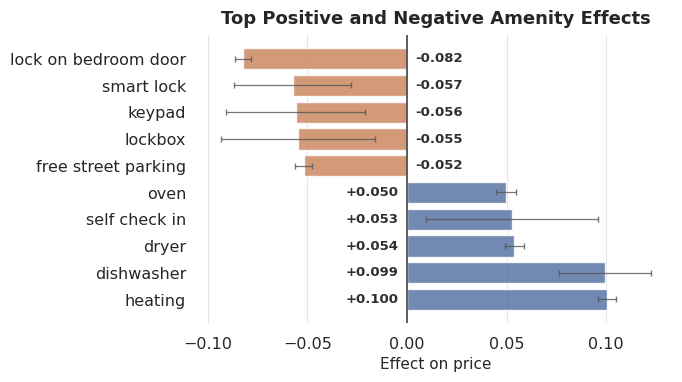

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Modern poster theme ---
sns.set_theme(
    style="white",
    font_scale=1.05,
    rc={
        "axes.grid": False,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

# -----------------------------
# Select top + bottom amenities
# -----------------------------
top_pos = final_conclusions.sort_values("coef_log_price", ascending=False).head(5)
top_neg = final_conclusions.sort_values("coef_log_price", ascending=True).head(5)

plot_df = pd.concat([top_neg, top_pos]).sort_values("coef_log_price")

# -----------------------------
# Color by sign
# -----------------------------
plot_df["bar_color"] = plot_df["coef_log_price"].apply(
    lambda x: "#4C72B0" if x > 0 else "#DD8452"  # blue / orange
)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7,4))

ax = sns.barplot(
    data=plot_df,
    x="coef_log_price",
    y="amenity_clean",
    palette=plot_df["bar_color"],
    alpha=0.85
)

# --- Subtle vertical grid ---
ax.xaxis.grid(True, color="#E6E6E6", linewidth=0.8)
ax.yaxis.grid(False)

# -----------------------------
# Error bars
# -----------------------------
for i, row in enumerate(plot_df.itertuples()):
    plt.errorbar(
        x=row.coef_log_price,
        y=i,
        xerr=row.coef_std_price,
        fmt="none",
        ecolor="#555555",
        capsize=2,
        linewidth=0.9,
        alpha=0.8
    )

# -----------------------------
# Coefficient annotations (anchored to zero)
# -----------------------------
for i, row in enumerate(plot_df.itertuples()):
    coef = row.coef_log_price

    if coef > 0:
        x_text, ha = -0.004, "right"
    else:
        x_text, ha = 0.004, "left"

    plt.text(
        x_text,
        i,
        f"{coef:+.3f}",
        va="center",
        ha=ha,
        fontsize=9.5,
        fontweight="semibold",
        color="#2F2F2F"
    )

# --- Zero line ---
plt.axvline(0, color="#444444", linewidth=1.2)

# -----------------------------
# Labels & title
# -----------------------------
plt.xlabel("Effect on price", fontsize=11)
plt.ylabel("")
plt.title(
    "Top Positive and Negative Amenity Effects",
    fontsize=13,
    weight="semibold",
    pad=8
)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

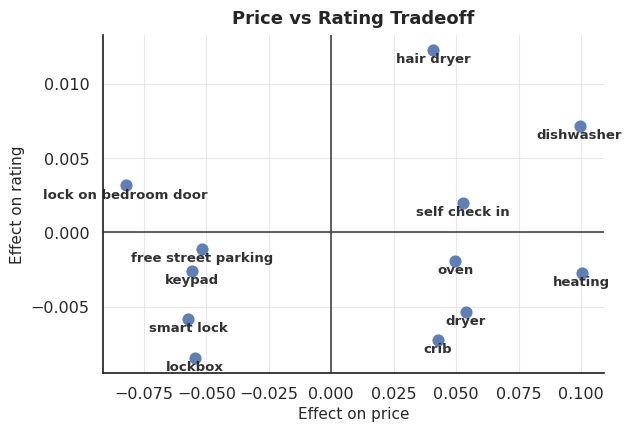

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- SAME poster theme ---
sns.set_theme(
    style="white",
    font_scale=1.05,
    rc={
        "axes.grid": False,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

# -----------------------------
# Select only significant amenities
# -----------------------------
tradeoff_df = final_conclusions.copy()

# Define overall impact
tradeoff_df["impact"] = (
    tradeoff_df["coef_log_price"].abs() +
    tradeoff_df["coef_rating"].abs()
)

TOP_K = 12  # adjust if needed (6–10 works best for posters)

plot_df = (
    tradeoff_df
    .sort_values("impact", ascending=False)
    .head(TOP_K)
)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(6.5, 4.5))

ax = sns.scatterplot(
    data=plot_df,
    x="coef_log_price",
    y="coef_rating",
    s=90,
    color="#4C72B0",
    alpha=0.9
)

# --- Zero reference lines ---
plt.axvline(0, color="#444444", linewidth=1.2)
plt.axhline(0, color="#444444", linewidth=1.2)

# --- Subtle grid ---
ax.xaxis.grid(True, color="#E6E6E6", linewidth=0.8)
ax.yaxis.grid(True, color="#E6E6E6", linewidth=0.8)

# -----------------------------
# Labels for ALL shown points
# -----------------------------
for _, row in plot_df.iterrows():
    plt.text(
        row["coef_log_price"],
        row["coef_rating"] - 0.0002,  # slight vertical offset downward
        row["amenity_clean"],
        fontsize=9.5,
        fontweight="semibold",
        ha="center",
        va="top",
        alpha=0.95
    )

# -----------------------------
# Labels & title
# -----------------------------
plt.xlabel("Effect on price", fontsize=11)
plt.ylabel("Effect on rating", fontsize=11)

plt.title(
    "Price vs Rating Tradeoff",
    fontsize=13,
    weight="semibold",
    pad=8
)

sns.despine()
plt.tight_layout()
plt.show()

# EDA

In [0]:
from pyspark.sql import functions as F

# Orders = number of rows
orders = airbnb.count()

# Hosts
hosts = (
    airbnb
    .select(F.col("seller_info"))
    .where(F.col("seller_info").isNotNull())
    .select(F.from_json("seller_info", "struct<seller_id:string>").alias("s"))
    .select("s.seller_id")
    .distinct()
    .count()
)

# Properties (prefer property_id / listing_id if exists)
property_id_col = next(
    (c for c in ["property_id", "listing_id", "id"] if c in airbnb.columns),
    None
)

properties = (
    airbnb
    .select(property_id_col)
    .distinct()
    .count()
)

amenities_schema = "array<struct<group_name:string, items:array<struct<name:string,value:string>>>>"

amenities_count = (
    airbnb
    .withColumn("amenities_parsed", F.from_json("amenities", amenities_schema))
    .withColumn("amenity", F.explode(F.expr("flatten(transform(amenities_parsed, g -> g.items))")))
    .select(F.lower("amenity.name").alias("amenity_name"))
    .distinct()
    .count()
)

# Parse reviews array
reviews_df = (
    airbnb
    .withColumn("reviews_parsed", F.from_json("reviews", "array<string>"))
    .withColumn("num_reviews", F.size("reviews_parsed"))
)

# Total reviews
total_reviews = (
    reviews_df
    .select(F.sum("num_reviews").alias("total"))
    .collect()[0]["total"]
)

# Reviews per property (average)
avg_reviews_per_property = (
    reviews_df
    .select(F.avg("num_reviews").alias("avg"))
    .collect()[0]["avg"]
)

print("Airbnb Data Statistics")
print("----------------------")
print(f"Orders: {orders:,}")
print(f"Hosts: {hosts:,}")
print(f"Properties: {properties:,}")
print(f"Amenities: {amenities_count:,}")
print(f"Reviews: {total_reviews:,}")
print(f"Reviews per Property (avg): {avg_reviews_per_property:.2f}")

Airbnb Data Statistics
----------------------
Orders: 2,098,880
Hosts: 1,287,798
Properties: 1,895,320
Amenities: 209,475
Reviews: 28,069,396
Reviews per Property (avg): 13.37


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

sns.set_theme(
    style="white",
    font_scale=1.05,
    rc={
        "axes.grid": False,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

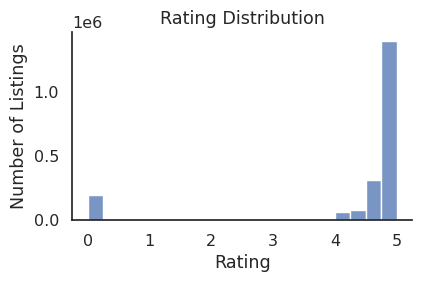

In [0]:
ratings_df = (
    airbnb
    .select(F.col("ratings").cast("double").alias("rating"))
    .where(F.col("rating").isNotNull())
    .toPandas()
)

plt.figure(figsize=(4.5,3))

sns.histplot(
    ratings_df["rating"],
    bins=20,
    color="#4C72B0",
    edgecolor="white"
)

plt.xlabel("Rating")
plt.ylabel("Number of Listings")
plt.title("Rating Distribution")

sns.despine()
plt.tight_layout()
plt.show()

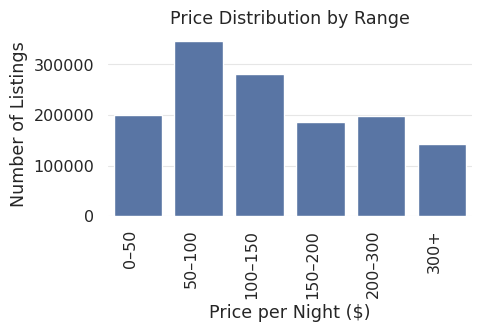

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare price data
price_df = (
    df
    .select(F.col("price_per_night").cast("double").alias("price"))
    .where((F.col("price") > 0) & (F.col("price") < 500))  # optional cap for clarity
    .toPandas()
)

# Define price bins
bins = [0, 50, 100, 150, 200, 300, 500]
labels = ["0–50", "50–100", "100–150", "150–200", "200–300", "300+"]

price_df["price_range"] = pd.cut(
    price_df["price"],
    bins=bins,
    labels=labels,
    right=False
)

# Plot
plt.figure(figsize=(5, 3.5))

ax = sns.countplot(
    data=price_df,
    x="price_range",
    color="#4C72B0"
)

ax.yaxis.grid(True, color="#E6E6E6", linewidth=0.8)
ax.xaxis.grid(False)

plt.xlabel("Price per Night ($)")
plt.ylabel("Number of Listings")
plt.title("Price Distribution by Range")

# 🔹 Rotate price range labels
plt.xticks(rotation=90, ha="right")

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

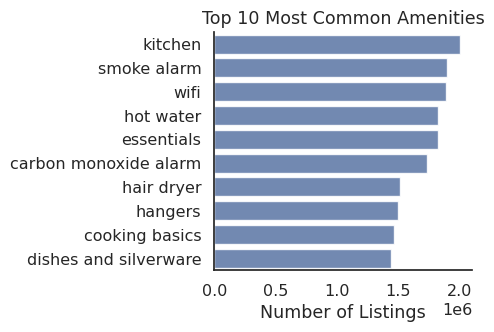

In [0]:
amenities_schema = """
array<struct<
    group_name:string,
    items:array<struct<name:string,value:string>>
>>
"""

top_amenities = (
    airbnb
    .withColumn("amenities_parsed", F.from_json("amenities", amenities_schema))
    .withColumn("amenity", F.explode(F.expr("flatten(transform(amenities_parsed, g -> g.items))")))
    .select(F.lower("amenity.name").alias("amenity"))
    .groupBy("amenity")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(5,3.5))

sns.barplot(
    data=top_amenities,
    x="count",
    y="amenity",
    color="#4C72B0",
    alpha=0.85
)

plt.xlabel("Number of Listings")
plt.ylabel("")
plt.title("Top 10 Most Common Amenities")

sns.despine()
plt.tight_layout()
plt.show()

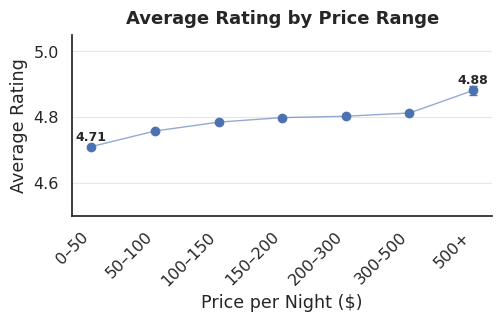

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
import numpy as np

# -----------------------------
# Poster theme
# -----------------------------
sns.set_theme(
    style="white",
    font_scale=1.05,
    rc={
        "axes.grid": False,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

# -----------------------------
# Prepare data
# -----------------------------
eda_df = (
    df
    .select(
        F.col("price_per_night").cast("double").alias("price"),
        F.col("ratings").cast("double").alias("rating")
    )
    .where(
        (F.col("price") > 0) &
        (F.col("price") <= 500) &
        (F.col("rating").between(1, 5))
    )
    .toPandas()
)

# Price ranges
bins = [0, 50, 100, 150, 200, 300, 500, 1000]
labels = ["0–50", "50–100", "100–150", "150–200", "200–300", "300-500", "500+"]

eda_df["price_range"] = pd.cut(
    eda_df["price"],
    bins=bins,
    labels=labels,
    right=False
)

# Aggregate: mean + CI
summary = (
    eda_df
    .groupby("price_range")
    .agg(
        mean_rating=("rating", "mean"),
        std_rating=("rating", "std"),
        n=("rating", "count")
    )
    .reset_index()
)

summary["ci"] = 1.96 * summary["std_rating"] / np.sqrt(summary["n"])

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(5.2, 3.4))

# Points + confidence intervals
plt.errorbar(
    x=summary["price_range"],
    y=summary["mean_rating"],
    yerr=summary["ci"],
    fmt="o",
    color="#4C72B0",
    ecolor="#4C72B0",
    elinewidth=1.2,
    capsize=3,
    markersize=6
)

# Subtle connecting trend line
plt.plot(
    summary["price_range"],
    summary["mean_rating"],
    color="#4C72B0",
    linewidth=1,
    alpha=0.6
)

# Subtle horizontal grid
plt.gca().yaxis.grid(True, color="#E6E6E6", linewidth=0.8)

# Annotate only min & max price ranges
for i in [0, len(summary) - 1]:
    plt.text(
        i,
        summary.loc[i, "mean_rating"] + 0.01,
        f'{summary.loc[i, "mean_rating"]:.2f}',
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="semibold"
    )

# Labels & title
plt.xlabel("Price per Night ($)")
plt.ylabel("Average Rating")
plt.title(
    "Average Rating by Price Range",
    fontsize=13,
    weight="semibold",
    pad=8
)

plt.ylim(4.5, 5.05)
plt.xticks(rotation=45, ha="right")

sns.despine()
plt.tight_layout()
plt.show()